# Import

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets, models
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt

import IPython.display as display
from PIL import Image
import pathlib
import os

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.4.0
Keras version 2.4.0
Found GPU at: /device:GPU:0


# Utility functions

In [2]:
IMG_WIDTH, IMG_HEIGHT = 224,224
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [3]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [4]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)


In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [6]:
models_dir = "/content/drive/MyDrive/Colab Notebooks/models/"

def savemodel(model, model_name):
    filename = os.path.join(models_dir, '%s.h5' %model_name)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)


def loadmodel(model_name):
    filename = os.path.join(models_dir, '%s.h5' %model_name)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:    
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    return model

In [7]:
def plot_accuracy_graph(mdl, ylower_limit=0.1, yupper_limit=1):
  plt.plot(mdl.history.history['accuracy'], label='accuracy')
  plt.plot(mdl.history.history['val_accuracy'], label = 'val_accuracy')
  plt.title('model accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([ylower_limit, yupper_limit])
  plt.legend(loc='lower right')

def plot_loss_graph(mdl, ylower_limit=0.5, yupper_limit=2):
  plt.plot(mdl.history.history['loss'], label='loss')
  plt.plot(mdl.history.history['val_loss'], label = 'val_loss')
  plt.title('model loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.ylim([ylower_limit, yupper_limit])
  plt.legend(loc='lower right')

# Custom CNN class

In [8]:
class CustomCNN:

    def _name(self):
        return "CustomCNN"

    def _cnn_block(self, model):
      model.add(layers.Conv2D(filters=self.filters, kernel_size=(3,3)))
      model.add(layers.BatchNormalization())
      model.add(layers.Dropout(0.2)) # 0.2 dropout rate 
      model.add(layers.MaxPool2D())

    def create_model(self):
        model = models.Sequential()

        # Part A
        # first layer
        model.add(layers.Conv2D(filters=self.filters, input_shape = self.input_shape, kernel_size=(3,3)))
        model.add(layers.ReLU())
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.2)) # 0.2 dropout rate 
        model.add(layers.MaxPool2D()) # Default: tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None,**kwargs)
        
        if self.num_layers > 1:
          for i in range(self.num_layers-1):
            print(i)
            self._cnn_block(model)

        # Part B
        model.add(layers.Flatten())
        model.add(layers.Dense(32))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(self.class_number))
        model.add(layers.Softmax())

        return model

    def __init__(self, input_shape, filters, class_number, num_layers):
        super().__init__()
        
        self.input_shape = input_shape
        self.filters = filters
        self.class_number = class_number
        self.num_layers = num_layers
        self.name = self._name()

# Load data

## Classic Dataset

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
train_plain_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/plain/"
train_plain_dir = pathlib.Path(train_plain_dir)
print("Path:", train_plain_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/plain


In [11]:
image_count = len(list(train_plain_dir.glob('*/*.png')))
print("Total number of images:", image_count)

image_dict = np.array([{item.name: len(list(item.glob('*.png')))} for item in train_plain_dir.glob('*') if item.name != "LICENSE.txt"])
print(image_dict)

Total number of images: 170
[{'Density4Benign': 10} {'Density1Benign': 19} {'Density3Malignant': 13}
 {'Density3Benign': 21} {'Density4Malignant': 2} {'Density2Benign': 6}
 {'Density1Malignant': 48} {'Density2Malignant': 51}]


In [12]:
CLASS_NAMES = np.array([item.name for item in train_plain_dir.glob('*') if item.name != "LICENSE.txt"])
print("Class names:",CLASS_NAMES)

Class names: ['Density4Benign' 'Density1Benign' 'Density3Malignant' 'Density3Benign'
 'Density4Malignant' 'Density2Benign' 'Density1Malignant'
 'Density2Malignant']


In [13]:
# # show examples
# density1benign = list(train_plain_dir.glob('Density1Benign/*'))

# for image_path in density1benign[:3]:
#     display.display(Image.open(str(image_path)))

## Load Crop Dataset

In [14]:
data_crop_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop/"
data_crop_dir = pathlib.Path(data_crop_dir)
print("Path:", data_crop_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop


## Load horizontal flip Dataset

In [15]:
data_hflip_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/horizontal_flip/"
data_hflip_dir = pathlib.Path(data_hflip_dir)
print("Path:", data_hflip_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/horizontal_flip


## Load vertical flip Dataset

In [16]:
data_vflip_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/vertical_flip/"
data_vflip_dir = pathlib.Path(data_vflip_dir)
print("Path:", data_vflip_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/vertical_flip


## Load brightness Dataset

In [17]:
data_brightness_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/brightness/"
data_brightness_dir = pathlib.Path(data_brightness_dir)
print("Path:", data_brightness_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/brightness


## Load cropped and vertical flipped Dataset

In [18]:
data_crop_vflip_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop_vflip/"
data_crop_vflip_dir = pathlib.Path(data_crop_vflip_dir)
print("Path:", data_crop_vflip_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop_vflip


## Load cropped, vertical and horizontal flipped Dataset

In [19]:
data_crop_vhflip_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop_vflip_hflip/"
data_crop_vhflip_dir = pathlib.Path(data_crop_vhflip_dir)
print("Path:", data_crop_vhflip_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop_vflip_hflip


## Load cropped, vertical and horizontal flipped and brightness Dataset

In [20]:
crop_vflip_hflip_brightness_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop_vflip_hflip_brightness/"
crop_vflip_hflip_brightness_dir = pathlib.Path(crop_vflip_hflip_brightness_dir)
print("Path:", crop_vflip_hflip_brightness_dir)

Path: /content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/crop_vflip_hflip_brightness


# Split data in train and test

## Classic Dataset

In [21]:
# Divide in train and validation
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_directory(
        directory=str(train_plain_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

Found 170 images belonging to 8 classes.


Found 43 images belonging to 8 classes.


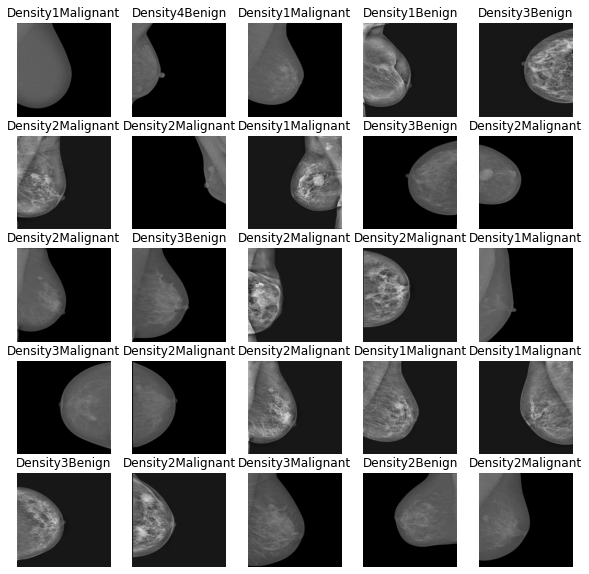

In [22]:
val_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Test/"
val_data_gen = image_generator.flow_from_directory(
        directory=val_dir,
        batch_size=32,
        shuffle=False,
        target_size=(224, 224),
        # subset="validation",
        classes = list(CLASS_NAMES))

# image_batch, label_batch = next(train_data_gen)
# show_batch(image_batch, label_batch)

## Cropped Dataset

Found 340 images belonging to 8 classes.


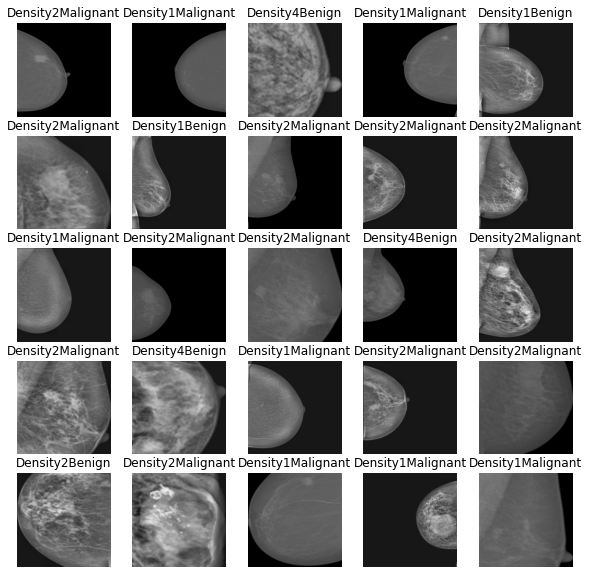

In [23]:
train_data_crop_gen = image_generator.flow_from_directory(
        directory=str(data_crop_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_crop_gen)
show_batch(image_batch, label_batch)

## Horizontal flip Dataset

Found 340 images belonging to 8 classes.


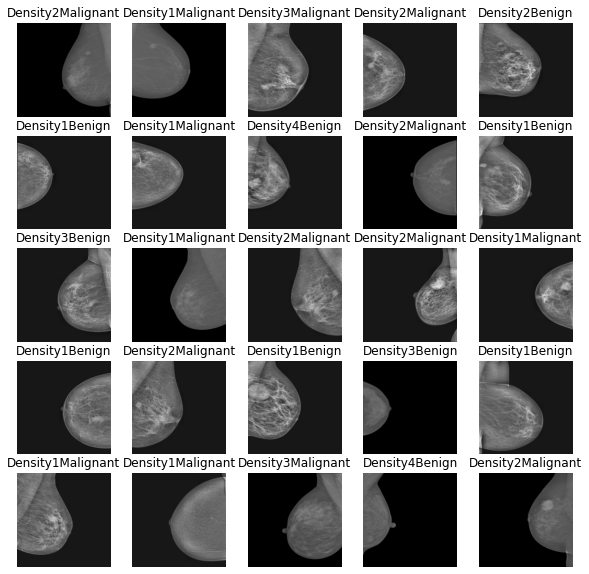

In [24]:
train_data_hflip_gen = image_generator.flow_from_directory(
        directory=str(data_hflip_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_hflip_gen)
show_batch(image_batch, label_batch)

## Vertical flip Dataset

Found 340 images belonging to 8 classes.


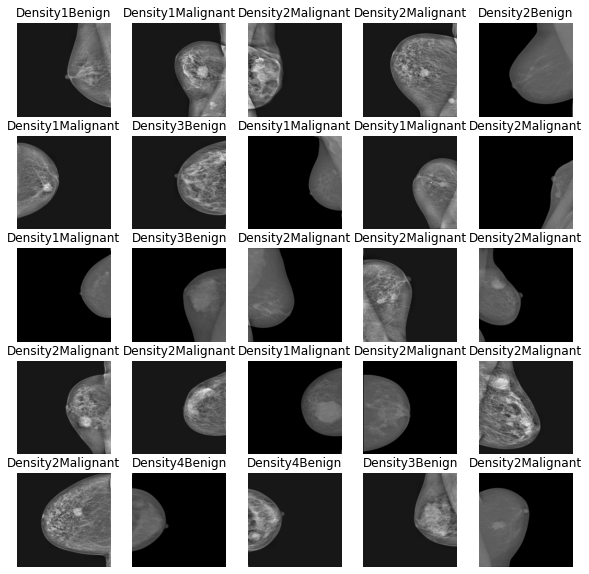

In [25]:
train_data_vflip_gen = image_generator.flow_from_directory(
        directory=str(data_vflip_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_vflip_gen)
show_batch(image_batch, label_batch)

## Brightness Dataset

Found 340 images belonging to 8 classes.


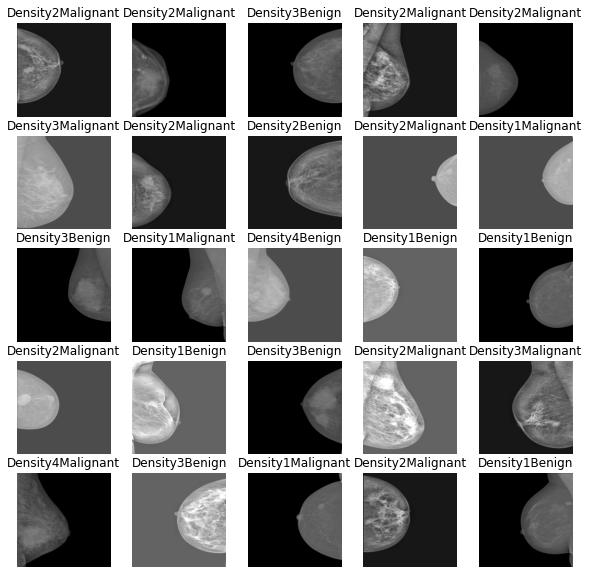

In [26]:
train_data_brightness_gen = image_generator.flow_from_directory(
        directory=str(data_brightness_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_brightness_gen)
show_batch(image_batch, label_batch)

## Cropped and vertical flipped Dataset

Found 680 images belonging to 8 classes.


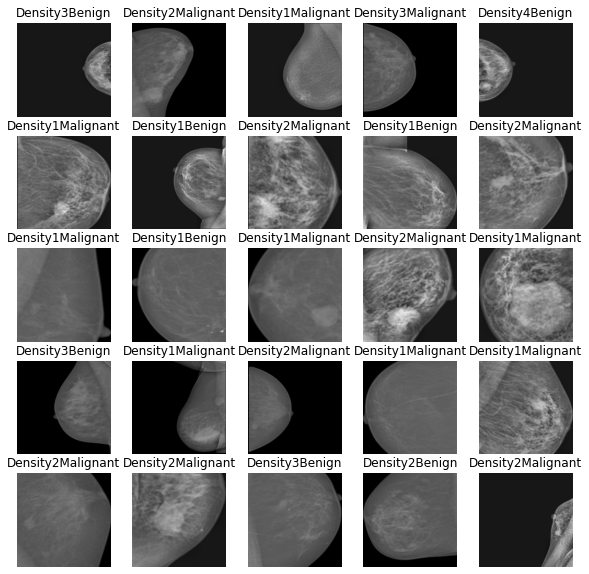

In [27]:
train_data_crop_vflip_gen = image_generator.flow_from_directory(
        directory=str(data_crop_vflip_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_crop_vflip_gen)
show_batch(image_batch, label_batch)

## Cropped, vertical and horizontal flipped Dataset

Found 1360 images belonging to 8 classes.


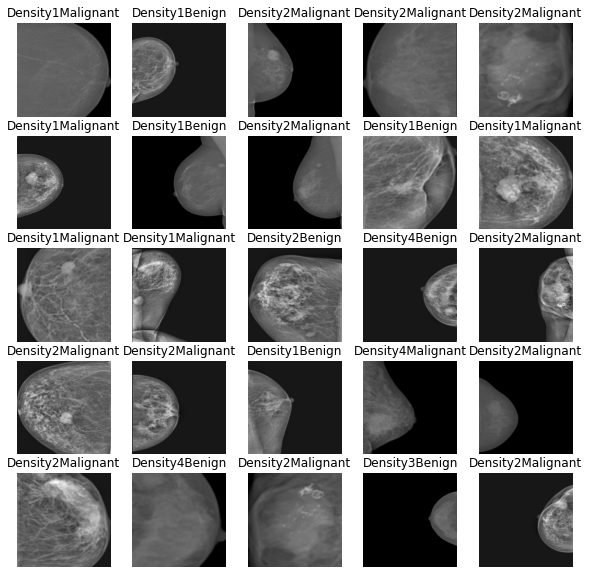

In [28]:
train_data_crop_vhflip_gen = image_generator.flow_from_directory(
        directory=str(data_crop_vhflip_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_crop_vhflip_gen)
show_batch(image_batch, label_batch)

## Cropped, vertical and horizontal flipped and brightness Dataset

Found 2896 images belonging to 8 classes.


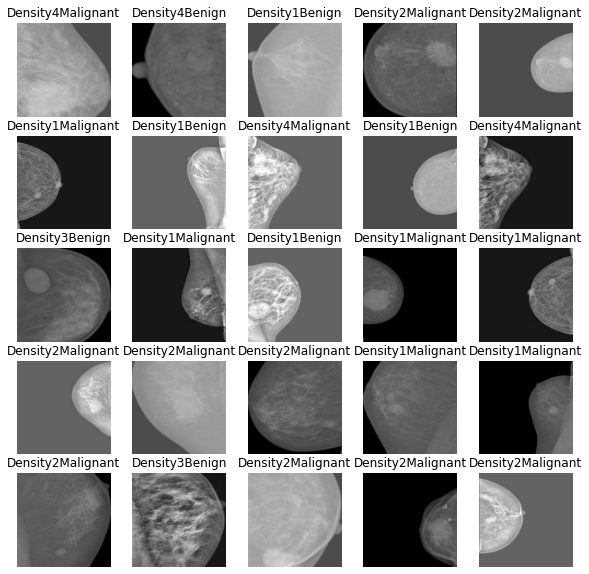

In [29]:
train_data_crop_vflip_hflip_brightness_gen = image_generator.flow_from_directory(
        directory=str(crop_vflip_hflip_brightness_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(train_data_crop_vflip_hflip_brightness_gen)
show_batch(image_batch, label_batch)

## Vertical and horizontal flipped and brightness Testset

Found 344 images belonging to 8 classes.


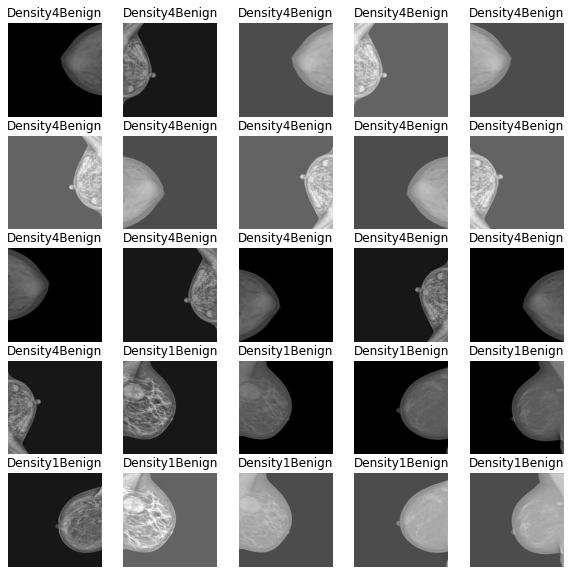

In [53]:
val_vhflip_brightness_dir = "/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Test/vflip_hflip_brightness"
val_data_vhflip_brightness_gen = image_generator.flow_from_directory(
        directory=val_vhflip_brightness_dir,
        batch_size=32,
        shuffle=False,
        target_size=(224, 224),
        # subset="validation",
        classes = list(CLASS_NAMES))

image_batch, label_batch = next(val_data_vhflip_brightness_gen)
show_batch(image_batch, label_batch)

# Inception

In [291]:
def inception():
  base_model = tf.keras.applications.InceptionV3(
    include_top=False, input_tensor=None, input_shape=None,
    pooling=None, classes=len(CLASS_NAMES), classifier_activation='softmax') 
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu')(x)
  predictions = layers.Dense(train_data_gen.num_classes, activation='softmax')(x)
  return keras.Model(inputs=base_model.input, outputs=predictions)

## Train on plain Dataset

In [233]:
inception = inception()
inception.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

In [234]:
callbacks_inception = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("inception.h5", save_best_only=True),
]
inception.fit(train_data_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_inception)

Epoch 1/100
6/6 [==============================] - 8s 472ms/step - loss: 3.0348 - accuracy: 0.1618 - val_loss: 8.4824 - val_accuracy: 0.3023
Epoch 2/100
6/6 [==============================] - 2s 237ms/step - loss: 1.5856 - accuracy: 0.4368 - val_loss: 12.4794 - val_accuracy: 0.0698
Epoch 3/100
6/6 [==============================] - 2s 242ms/step - loss: 1.5488 - accuracy: 0.4870 - val_loss: 11.2452 - val_accuracy: 0.3023
Epoch 4/100
6/6 [==============================] - 1s 269ms/step - loss: 1.4011 - accuracy: 0.4303 - val_loss: 11.2452 - val_accuracy: 0.3023
Epoch 5/100
6/6 [==============================] - 1s 239ms/step - loss: 1.1209 - accuracy: 0.5904 - val_loss: 7.2417 - val_accuracy: 0.4186
Epoch 6/100
6/6 [==============================] - 1s 269ms/step - loss: 1.0624 - accuracy: 0.5740 - val_loss: 11.2937 - val_accuracy: 0.2791
Epoch 7/100
6/6 [==============================] - 1s 238ms/step - loss: 0.9575 - accuracy: 0.6958 - val_loss: 12.5966 - val_accuracy: 0.1163
Epoch 8/

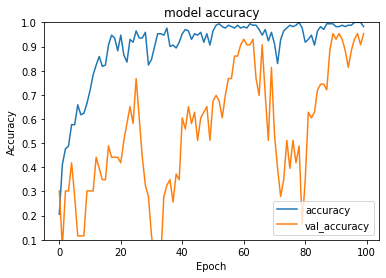

In [235]:
plot_accuracy_graph(inception)

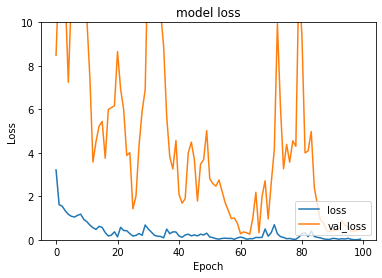

In [236]:
plot_loss_graph(inception, 0, 10)

In [237]:
try:
  best_inception = models.load_model("inception.h5")
except OSError as error:
  print(error)
  best_inception = loadmodel('best_inception')
best_inception.evaluate(val_data_gen)

2/2 [==============================] - 1s 51ms/step - loss: 0.2546 - accuracy: 0.9302


[0.2545655369758606, 0.930232584476471]

In [238]:
savemodel(best_inception, 'best_inception')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception.h5



## Train on cropped Dataset

In [292]:
inception_cropped = inception()
inception_cropped.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

In [293]:
callbacks_inception_cropped = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_crop.h5", save_best_only=True),
]
inception_cropped.fit(train_data_crop_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_cropped)

Epoch 1/50
11/11 [==============================] - 10s 365ms/step - loss: 2.7994 - accuracy: 0.2115 - val_loss: 14.2381 - val_accuracy: 0.1163
Epoch 2/50
11/11 [==============================] - 3s 237ms/step - loss: 1.8265 - accuracy: 0.3679 - val_loss: 11.6200 - val_accuracy: 0.2791
Epoch 3/50
11/11 [==============================] - 3s 239ms/step - loss: 1.7287 - accuracy: 0.3891 - val_loss: 14.9936 - val_accuracy: 0.0698
Epoch 4/50
11/11 [==============================] - 3s 239ms/step - loss: 1.5861 - accuracy: 0.4888 - val_loss: 14.5109 - val_accuracy: 0.0698
Epoch 5/50
11/11 [==============================] - 3s 241ms/step - loss: 1.4370 - accuracy: 0.5037 - val_loss: 3.1850 - val_accuracy: 0.1860
Epoch 6/50
11/11 [==============================] - 3s 239ms/step - loss: 1.4685 - accuracy: 0.4770 - val_loss: 1.9537 - val_accuracy: 0.3721
Epoch 7/50
11/11 [==============================] - 3s 243ms/step - loss: 1.3079 - accuracy: 0.5238 - val_loss: 2.7607 - val_accuracy: 0.3256
E

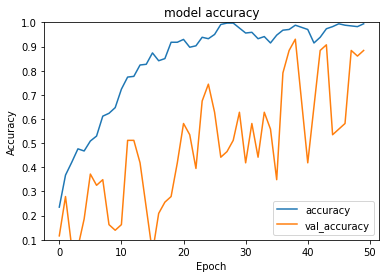

In [294]:
plot_accuracy_graph(inception_cropped)

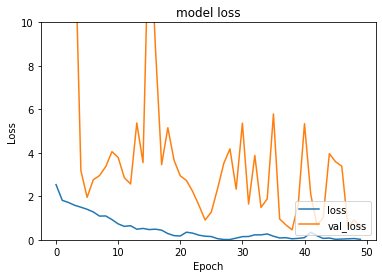

In [295]:
plot_loss_graph(inception_cropped, 0, 10)

In [296]:
try:
  best_inception_crop = models.load_model("inception_crop.h5")
except NameError as error:
  print(error)
  best_inception_crop = loadmodel('best_inception_cropped')
  
best_inception_crop.evaluate(val_data_gen)

2/2 [==============================] - 1s 51ms/step - loss: 0.4595 - accuracy: 0.9302


[0.45951125025749207, 0.930232584476471]

In [297]:
savemodel(best_inception_crop, 'best_inception_crop')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_crop.h5



## Train on horizontal flip Dataset

In [298]:
inception_hflip = inception()
inception_hflip.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

In [299]:
callbacks_inception_hflip = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_hflip.h5", save_best_only=True),
]
inception_hflip.fit(train_data_hflip_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_hflip)

Epoch 1/50
11/11 [==============================] - 10s 388ms/step - loss: 2.8466 - accuracy: 0.2220 - val_loss: 3.8698 - val_accuracy: 0.3023
Epoch 2/50
11/11 [==============================] - 3s 250ms/step - loss: 1.7718 - accuracy: 0.3598 - val_loss: 7.3845 - val_accuracy: 0.1395
Epoch 3/50
11/11 [==============================] - 3s 251ms/step - loss: 1.5785 - accuracy: 0.4599 - val_loss: 5.6609 - val_accuracy: 0.2791
Epoch 4/50
11/11 [==============================] - 3s 252ms/step - loss: 1.5875 - accuracy: 0.3914 - val_loss: 3.1979 - val_accuracy: 0.3721
Epoch 5/50
11/11 [==============================] - 3s 249ms/step - loss: 1.4216 - accuracy: 0.4547 - val_loss: 4.4343 - val_accuracy: 0.2791
Epoch 6/50
11/11 [==============================] - 3s 250ms/step - loss: 1.0714 - accuracy: 0.6282 - val_loss: 1.6174 - val_accuracy: 0.3488
Epoch 7/50
11/11 [==============================] - 3s 250ms/step - loss: 1.0553 - accuracy: 0.6285 - val_loss: 3.5744 - val_accuracy: 0.2093
Epoch

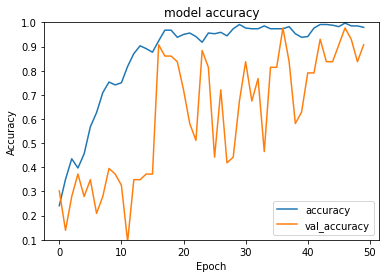

In [300]:
plot_accuracy_graph(inception_hflip)

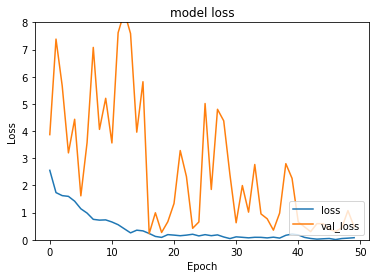

In [301]:
plot_loss_graph(inception_hflip, 0, 8)

In [302]:
try:
  best_inception_hflip = models.load_model("inception_hflip.h5")
except NameError as error:
  print(error)
  best_inception_hflip = loadmodel('best_inception_hflip')

best_inception_hflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 53ms/step - loss: 0.2274 - accuracy: 0.9070


[0.2273889183998108, 0.9069767594337463]

In [303]:
savemodel(best_inception_hflip, 'best_inception_hflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_hflip.h5



## Train on vertical flip Dataset

In [304]:
inception_vflip = inception()
inception_vflip.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

In [305]:
callbacks_inception_vflip = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_vflip.h5", save_best_only=True),
]
inception_vflip.fit(train_data_vflip_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_vflip)

Epoch 1/50
11/11 [==============================] - 10s 365ms/step - loss: 2.5039 - accuracy: 0.2468 - val_loss: 5.7616 - val_accuracy: 0.3953
Epoch 2/50
11/11 [==============================] - 3s 251ms/step - loss: 1.5837 - accuracy: 0.4612 - val_loss: 11.2452 - val_accuracy: 0.3023
Epoch 3/50
11/11 [==============================] - 3s 253ms/step - loss: 1.2196 - accuracy: 0.5832 - val_loss: 8.0611 - val_accuracy: 0.2558
Epoch 4/50
11/11 [==============================] - 3s 253ms/step - loss: 1.0730 - accuracy: 0.6092 - val_loss: 11.6200 - val_accuracy: 0.2791
Epoch 5/50
11/11 [==============================] - 3s 253ms/step - loss: 0.8245 - accuracy: 0.7096 - val_loss: 11.6200 - val_accuracy: 0.2791
Epoch 6/50
11/11 [==============================] - 3s 254ms/step - loss: 0.5914 - accuracy: 0.8072 - val_loss: 11.6200 - val_accuracy: 0.2791
Epoch 7/50
11/11 [==============================] - 3s 253ms/step - loss: 0.4624 - accuracy: 0.8278 - val_loss: 7.5185 - val_accuracy: 0.3023
E

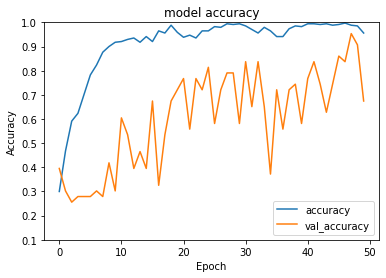

In [306]:
plot_accuracy_graph(inception_vflip)

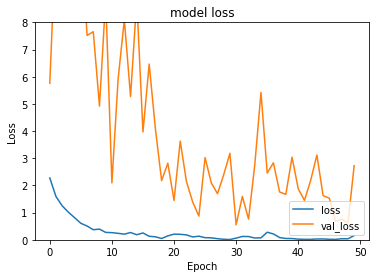

In [307]:
plot_loss_graph(inception_vflip, 0, 8)

In [308]:
try:
  best_inception_vflip = models.load_model("inception_vflip.h5")
except NameError as error:
  print(error)
  best_inception_vflip = loadmodel('best_inception_vflip')
  
best_inception_vflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 50ms/step - loss: 0.5519 - accuracy: 0.8372


[0.5518697500228882, 0.8372092843055725]

In [309]:
savemodel(best_inception_vflip, 'best_inception_vflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_vflip.h5



## Train on brightness Dataset

In [310]:
inception_brightness = inception()
inception_brightness.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

In [311]:
callbacks_inception_brightness = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_brightness.h5", save_best_only=True),
]
inception_brightness.fit(train_data_brightness_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_brightness)

Epoch 1/50
11/11 [==============================] - 10s 389ms/step - loss: 2.9254 - accuracy: 0.2831 - val_loss: 1.9732 - val_accuracy: 0.1395
Epoch 2/50
11/11 [==============================] - 3s 253ms/step - loss: 1.5269 - accuracy: 0.4927 - val_loss: 8.1963 - val_accuracy: 0.2791
Epoch 3/50
11/11 [==============================] - 3s 253ms/step - loss: 1.3011 - accuracy: 0.5582 - val_loss: 8.1184 - val_accuracy: 0.0465
Epoch 4/50
11/11 [==============================] - 3s 253ms/step - loss: 0.8397 - accuracy: 0.7316 - val_loss: 5.4708 - val_accuracy: 0.3953
Epoch 5/50
11/11 [==============================] - 3s 255ms/step - loss: 0.5851 - accuracy: 0.7850 - val_loss: 10.5107 - val_accuracy: 0.1163
Epoch 6/50
11/11 [==============================] - 3s 263ms/step - loss: 0.4174 - accuracy: 0.8892 - val_loss: 2.8086 - val_accuracy: 0.2326
Epoch 7/50
11/11 [==============================] - 3s 256ms/step - loss: 0.2689 - accuracy: 0.9064 - val_loss: 6.6296 - val_accuracy: 0.1860
Epoc

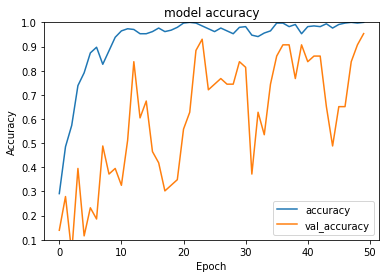

In [312]:
plot_accuracy_graph(inception_brightness)

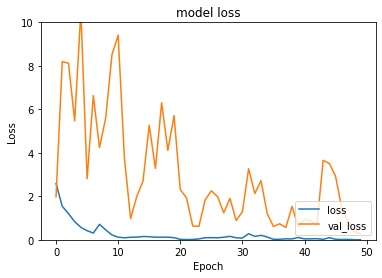

In [313]:
plot_loss_graph(inception_brightness, 0, 10)

In [314]:
try:
  best_inception_brightness = models.load_model("inception_brightness.h5")
except NameError as error:
  print(error)
  best_inception_brightness = loadmodel('best_inception_brightness')

best_inception_brightness.evaluate(val_data_gen)

2/2 [==============================] - 1s 46ms/step - loss: 0.2834 - accuracy: 0.9535


[0.2833547592163086, 0.9534883499145508]

In [315]:
savemodel(best_inception_brightness, 'best_inception_brightness')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_brightness.h5



##Train on cropped and vertical flip Dataset

In [316]:
inception_crop_vflip = inception()
inception_crop_vflip.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

In [317]:
callbacks_inception_crop_vflip = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_crop_vflip.h5", save_best_only=True),
]
inception_crop_vflip.fit(train_data_crop_vflip_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_crop_vflip)

Epoch 1/50
22/22 [==============================] - 13s 302ms/step - loss: 2.3549 - accuracy: 0.2982 - val_loss: 9.9247 - val_accuracy: 0.2791
Epoch 2/50
22/22 [==============================] - 5s 244ms/step - loss: 1.6204 - accuracy: 0.4258 - val_loss: 11.5427 - val_accuracy: 0.2791
Epoch 3/50
22/22 [==============================] - 5s 245ms/step - loss: 1.5757 - accuracy: 0.4467 - val_loss: 8.9479 - val_accuracy: 0.3023
Epoch 4/50
22/22 [==============================] - 5s 243ms/step - loss: 1.4689 - accuracy: 0.4945 - val_loss: 4.4346 - val_accuracy: 0.2326
Epoch 5/50
22/22 [==============================] - 5s 244ms/step - loss: 1.1635 - accuracy: 0.5940 - val_loss: 2.9702 - val_accuracy: 0.1163
Epoch 6/50
22/22 [==============================] - 5s 252ms/step - loss: 0.9382 - accuracy: 0.6741 - val_loss: 2.2635 - val_accuracy: 0.2558
Epoch 7/50
22/22 [==============================] - 5s 244ms/step - loss: 0.7188 - accuracy: 0.7486 - val_loss: 7.1971 - val_accuracy: 0.0698
Epoc

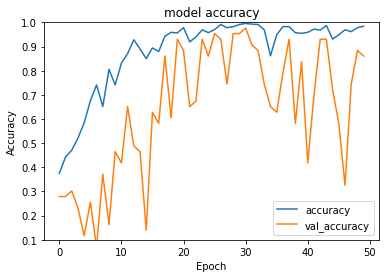

In [318]:
plot_accuracy_graph(inception_crop_vflip)

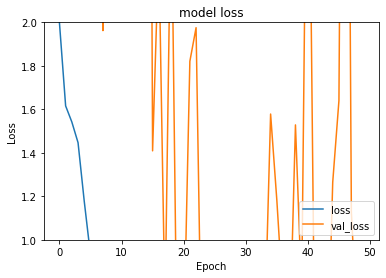

In [319]:
plot_loss_graph(inception_crop_vflip, 1, 2)

In [320]:
try:
  best_inception_crop_vflip = models.load_model("inception_crop_vflip.h5")
except NameError as error:
  print(error)
  best_inception_crop_vflip = loadmodel('best_inception_crop_vflip')

best_inception_crop_vflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 44ms/step - loss: 0.1954 - accuracy: 0.9302


[0.19538196921348572, 0.930232584476471]

In [321]:
savemodel(best_inception_crop_vflip, 'best_inception_crop_vflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_crop_vflip.h5



## Train on cropped, vertical and horizontal flip Dataset

In [322]:
inception_crop_vhflip = inception()
inception_crop_vhflip.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

In [323]:
callbacks_inception_crop_vhflip = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_crop_vhflip.h5", save_best_only=True),
]
inception_crop_vhflip.fit(train_data_crop_vhflip_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_crop_vhflip)

Epoch 1/50
43/43 [==============================] - 18s 274ms/step - loss: 2.0445 - accuracy: 0.2830 - val_loss: 3.2354 - val_accuracy: 0.2791
Epoch 2/50
43/43 [==============================] - 11s 250ms/step - loss: 1.7331 - accuracy: 0.3241 - val_loss: 10.9628 - val_accuracy: 0.3023
Epoch 3/50
43/43 [==============================] - 11s 251ms/step - loss: 1.6740 - accuracy: 0.3495 - val_loss: 11.2452 - val_accuracy: 0.3023
Epoch 4/50
43/43 [==============================] - 11s 247ms/step - loss: 1.7407 - accuracy: 0.3386 - val_loss: 4.1989 - val_accuracy: 0.3488
Epoch 5/50
43/43 [==============================] - 11s 246ms/step - loss: 1.6521 - accuracy: 0.3674 - val_loss: 5.4949 - val_accuracy: 0.2791
Epoch 6/50
43/43 [==============================] - 11s 246ms/step - loss: 1.7138 - accuracy: 0.3408 - val_loss: 2.3301 - val_accuracy: 0.3721
Epoch 7/50
43/43 [==============================] - 11s 246ms/step - loss: 1.5292 - accuracy: 0.4335 - val_loss: 6.0254 - val_accuracy: 0.23

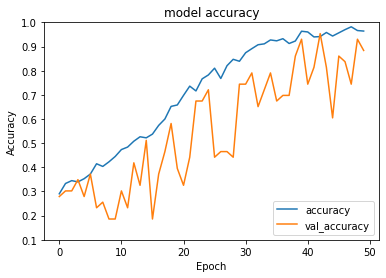

In [324]:
plot_accuracy_graph(inception_crop_vhflip)

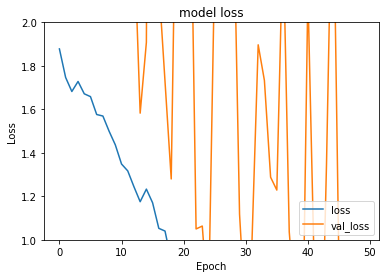

In [325]:
plot_loss_graph(inception_crop_vhflip, 1, 2)

In [326]:
try:
  best_inception_crop_vhflip = models.load_model("inception_crop_vhflip.h5")
except NameError as error:
  print(error)
  best_inception_crop_vhflip = loadmodel('best_inception_crop_vhflip')

best_inception_crop_vhflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 47ms/step - loss: 0.1640 - accuracy: 0.9535


[0.16400296986103058, 0.9534883499145508]

In [327]:
savemodel(best_inception_crop_vhflip, 'best_inception_crop_vhflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_crop_vhflip.h5



## Train on cropped, vertical, horizontal and brightness Dataset

In [328]:
inception_crop_vhflip_brightness = inception()
inception_crop_vhflip_brightness.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'] )

In [329]:
callbacks_inception_crop_vhflip_brightness = [
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("inception_crop_vhflip_brigthtness.h5", save_best_only=True),
]
inception_crop_vhflip_brightness.fit(train_data_crop_vflip_hflip_brightness_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_inception_crop_vhflip_brightness)

Epoch 1/50
91/91 [==============================] - 32s 261ms/step - loss: 2.1356 - accuracy: 0.2779 - val_loss: 4.4948 - val_accuracy: 0.2791
Epoch 2/50
91/91 [==============================] - 23s 249ms/step - loss: 1.5492 - accuracy: 0.4208 - val_loss: 1.8253 - val_accuracy: 0.3721
Epoch 3/50
91/91 [==============================] - 22s 245ms/step - loss: 1.1091 - accuracy: 0.5711 - val_loss: 1.1184 - val_accuracy: 0.6744
Epoch 4/50
91/91 [==============================] - 23s 247ms/step - loss: 0.6604 - accuracy: 0.7605 - val_loss: 3.3652 - val_accuracy: 0.5581
Epoch 5/50
91/91 [==============================] - 23s 249ms/step - loss: 0.3621 - accuracy: 0.8808 - val_loss: 4.6735 - val_accuracy: 0.4186
Epoch 6/50
91/91 [==============================] - 23s 247ms/step - loss: 0.2827 - accuracy: 0.9172 - val_loss: 0.5498 - val_accuracy: 0.8837
Epoch 7/50
91/91 [==============================] - 23s 247ms/step - loss: 0.2219 - accuracy: 0.9301 - val_loss: 0.2495 - val_accuracy: 0.9070

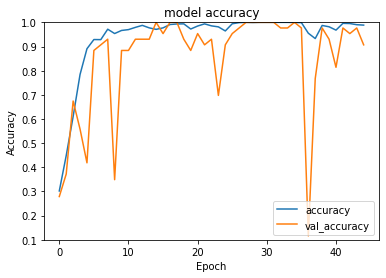

In [330]:
plot_accuracy_graph(inception_crop_vhflip_brightness)

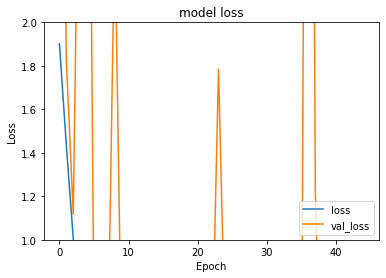

In [331]:
plot_loss_graph(inception_crop_vhflip_brightness, 1, 2)

In [67]:
try:
  best_inception_crop_vhflip_brigthtness = models.load_model("inception_crop_vhflip_brightness.h5")
except OSError as error:
  print(error)
  best_inception_crop_vhflip_brigthtness = loadmodel('inception_crop_vhflip_brightness')
  
best_inception_crop_vhflip_brigthtness.evaluate(val_data_gen)

SavedModel file does not exist at: inception_crop_vhflip_brightness.h5/{saved_model.pbtxt|saved_model.pb}

Model loaded successfully from file /content/drive/MyDrive/Colab Notebooks/models/inception_crop_vhflip_brightness.h5

2/2 [==============================] - 2s 432ms/step - loss: 0.0799 - accuracy: 0.9767


[0.07991671562194824, 0.9767441749572754]

In [68]:
best_inception_crop_vhflip_brigthtness.evaluate(val_data_vhflip_brightness_gen)

11/11 [==============================] - 2s 148ms/step - loss: 0.2765 - accuracy: 0.9157


[0.27650079131126404, 0.9156976938247681]

In [69]:
preds = best_inception_crop_vhflip_brigthtness.predict(val_data_vhflip_brightness_gen,verbose=1)

Ypred = np.argmax(preds, axis=1)
Ytest = val_data_vhflip_brightness_gen.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=CLASS_NAMES, digits=3))

11/11 [==============================] - 2s 102ms/step
                   precision    recall  f1-score   support

   Density4Benign      0.593     1.000     0.744        16
   Density1Benign      1.000     1.000     1.000        40
Density3Malignant      0.852     0.958     0.902        24
   Density3Benign      0.941     0.800     0.865        40
Density4Malignant      1.000     1.000     1.000         8
   Density2Benign      0.889     1.000     0.941        16
Density1Malignant      0.966     0.896     0.930        96
Density2Malignant      0.931     0.904     0.917       104

         accuracy                          0.916       344
        macro avg      0.896     0.945     0.912       344
     weighted avg      0.928     0.916     0.918       344



In [333]:
savemodel(best_inception_crop_vhflip_brigthtness, 'best_inception_crop_vhflip_brightness')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_inception_crop_vhflip_brightness.h5



# VGG19

In [31]:
# VGG
def VGG():
  base_model = tf.keras.applications.VGG19(include_top=False, input_tensor=None, input_shape=None,
    pooling=None, classes=len(CLASS_NAMES), classifier_activation='softmax') 
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu')(x)
  predictions = layers.Dense(train_data_gen.num_classes, activation='softmax')(x)
  return keras.Model(inputs=base_model.input, outputs=predictions)

## Train on plain Dataset

In [335]:
VGG = VGG()
VGG.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [336]:
callbacks_vgg = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("vgg.h5", save_best_only=True),
]

VGG.fit(train_data_gen, epochs=100, 
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg)

Epoch 1/100
6/6 [==============================] - 4s 558ms/step - loss: 1.9546 - accuracy: 0.2033 - val_loss: 1.8349 - val_accuracy: 0.2791
Epoch 2/100
6/6 [==============================] - 3s 513ms/step - loss: 1.8036 - accuracy: 0.2863 - val_loss: 1.7679 - val_accuracy: 0.2791
Epoch 3/100
6/6 [==============================] - 3s 512ms/step - loss: 1.6764 - accuracy: 0.3521 - val_loss: 1.7523 - val_accuracy: 0.3488
Epoch 4/100
6/6 [==============================] - 3s 514ms/step - loss: 1.7188 - accuracy: 0.4124 - val_loss: 1.7571 - val_accuracy: 0.3953
Epoch 5/100
6/6 [==============================] - 3s 523ms/step - loss: 1.6637 - accuracy: 0.4396 - val_loss: 1.7695 - val_accuracy: 0.3023
Epoch 6/100
6/6 [==============================] - 3s 592ms/step - loss: 1.6679 - accuracy: 0.4008 - val_loss: 1.7298 - val_accuracy: 0.4186
Epoch 7/100
6/6 [==============================] - 3s 536ms/step - loss: 1.6994 - accuracy: 0.4222 - val_loss: 1.7143 - val_accuracy: 0.3721
Epoch 8/100
6

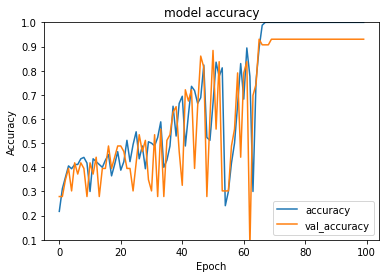

In [337]:
plot_accuracy_graph(VGG)

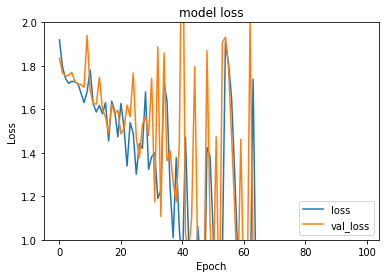

In [338]:
plot_loss_graph(VGG, 1, 2)

In [339]:
try:
  best_vgg = models.load_model("vgg.h5")
except NameError as error:
  print(error)
  best_vgg = loadmodel('best_vgg')
  
best_vgg.evaluate(val_data_gen)

2/2 [==============================] - 1s 76ms/step - loss: 0.4396 - accuracy: 0.9070


[0.43964165449142456, 0.9069767594337463]

In [340]:
savemodel(best_vgg, 'best_vgg')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg.h5



## Train on cropped Dataset

In [343]:
vgg_cropped = VGG()
vgg_cropped.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [344]:
callbacks_vgg_crop = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("vgg_crop.h5", save_best_only=True),
]

vgg_cropped.fit(train_data_crop_gen, epochs=100,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_crop)

Epoch 1/100
11/11 [==============================] - 9s 750ms/step - loss: 2.0016 - accuracy: 0.2296 - val_loss: 1.8823 - val_accuracy: 0.3023
Epoch 2/100
11/11 [==============================] - 5s 488ms/step - loss: 1.8094 - accuracy: 0.3316 - val_loss: 1.7531 - val_accuracy: 0.3721
Epoch 3/100
11/11 [==============================] - 5s 488ms/step - loss: 1.7236 - accuracy: 0.3950 - val_loss: 1.7679 - val_accuracy: 0.3953
Epoch 4/100
11/11 [==============================] - 5s 491ms/step - loss: 1.7250 - accuracy: 0.3659 - val_loss: 1.7616 - val_accuracy: 0.3488
Epoch 5/100
11/11 [==============================] - 5s 494ms/step - loss: 1.7220 - accuracy: 0.3952 - val_loss: 1.7423 - val_accuracy: 0.3721
Epoch 6/100
11/11 [==============================] - 5s 494ms/step - loss: 1.7583 - accuracy: 0.3734 - val_loss: 1.7116 - val_accuracy: 0.3488
Epoch 7/100
11/11 [==============================] - 5s 507ms/step - loss: 1.6524 - accuracy: 0.4329 - val_loss: 1.7284 - val_accuracy: 0.3721

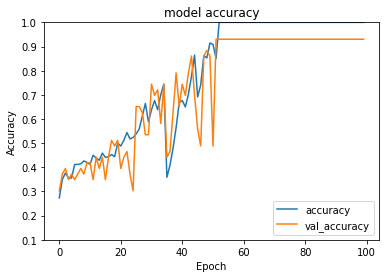

In [345]:
plot_accuracy_graph(vgg_cropped)

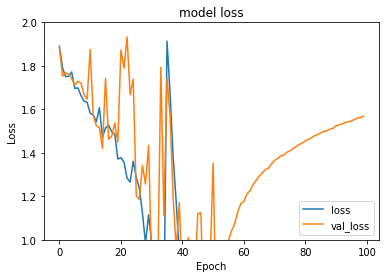

In [346]:
plot_loss_graph(vgg_cropped, 1, 2)

In [347]:
try:
  best_vgg_crop = models.load_model("vgg_crop.h5")
except NameError as error:
  print(error)
  best_vgg_crop = loadmodel('best_vgg_cropped')

best_vgg_crop.evaluate(val_data_gen)

2/2 [==============================] - 0s 74ms/step - loss: 0.6414 - accuracy: 0.9302


[0.6413601040840149, 0.930232584476471]

In [348]:
savemodel(best_vgg_crop, 'best_vgg_crop')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_crop.h5



## Train on horizontal flip Dataset

In [349]:
vgg_hflip = VGG()
vgg_hflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [350]:
callbacks_vgg_hflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("vgg_hflip.h5", save_best_only=True),
]

vgg_hflip.fit(train_data_hflip_gen, epochs=100,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_hflip)

Epoch 1/100
11/11 [==============================] - 7s 548ms/step - loss: 1.9204 - accuracy: 0.2387 - val_loss: 1.8177 - val_accuracy: 0.3023
Epoch 2/100
11/11 [==============================] - 6s 537ms/step - loss: 1.7773 - accuracy: 0.3034 - val_loss: 1.7665 - val_accuracy: 0.3953
Epoch 3/100
11/11 [==============================] - 6s 531ms/step - loss: 1.7871 - accuracy: 0.2903 - val_loss: 1.7808 - val_accuracy: 0.3023
Epoch 4/100
11/11 [==============================] - 6s 533ms/step - loss: 1.7424 - accuracy: 0.3024 - val_loss: 1.7476 - val_accuracy: 0.3488
Epoch 5/100
11/11 [==============================] - 6s 532ms/step - loss: 1.7354 - accuracy: 0.3444 - val_loss: 1.7421 - val_accuracy: 0.3023
Epoch 6/100
11/11 [==============================] - 6s 534ms/step - loss: 1.7035 - accuracy: 0.3614 - val_loss: 1.7265 - val_accuracy: 0.3721
Epoch 7/100
11/11 [==============================] - 6s 536ms/step - loss: 1.7245 - accuracy: 0.3325 - val_loss: 1.7084 - val_accuracy: 0.3953

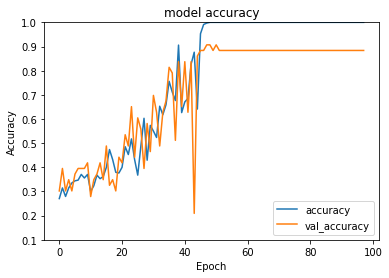

In [351]:
plot_accuracy_graph(vgg_hflip)

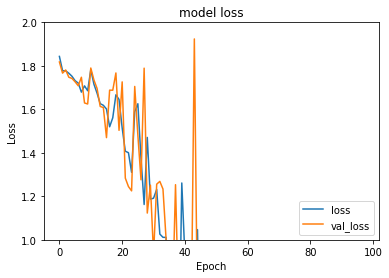

In [352]:
plot_loss_graph(vgg_hflip, 1, 2)

In [353]:
try:
  best_vgg_hflip = models.load_model("vgg_hflip.h5")
except NameError as error:
  print(error)
  best_vgg_hflip = loadmodel('best_vgg_hflip')

best_vgg_hflip.evaluate(val_data_gen)

2/2 [==============================] - 0s 72ms/step - loss: 0.3176 - accuracy: 0.9070


[0.31758105754852295, 0.9069767594337463]

In [354]:
savemodel(best_vgg_hflip, 'best_vgg_hflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_hflip.h5



## Train on vertical flip Dataset

In [355]:
vgg_vflip = VGG()
vgg_vflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [356]:
callbacks_vgg_vflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("vgg_vflip.h5", save_best_only=True),
]

vgg_vflip.fit(train_data_vflip_gen, epochs=100,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_vflip)

Epoch 1/100
11/11 [==============================] - 8s 546ms/step - loss: 1.9073 - accuracy: 0.2266 - val_loss: 1.7707 - val_accuracy: 0.2791
Epoch 2/100
11/11 [==============================] - 6s 524ms/step - loss: 1.7476 - accuracy: 0.2887 - val_loss: 1.7395 - val_accuracy: 0.3488
Epoch 3/100
11/11 [==============================] - 6s 532ms/step - loss: 1.6957 - accuracy: 0.3830 - val_loss: 1.7252 - val_accuracy: 0.4186
Epoch 4/100
11/11 [==============================] - 6s 542ms/step - loss: 1.6632 - accuracy: 0.4037 - val_loss: 1.7279 - val_accuracy: 0.4419
Epoch 5/100
11/11 [==============================] - 6s 546ms/step - loss: 1.6887 - accuracy: 0.3951 - val_loss: 1.7742 - val_accuracy: 0.3488
Epoch 6/100
11/11 [==============================] - 6s 542ms/step - loss: 1.6364 - accuracy: 0.4337 - val_loss: 1.6733 - val_accuracy: 0.4186
Epoch 7/100
11/11 [==============================] - 6s 534ms/step - loss: 1.6124 - accuracy: 0.4440 - val_loss: 1.6177 - val_accuracy: 0.3953

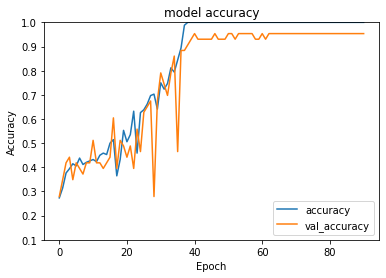

In [357]:
plot_accuracy_graph(vgg_vflip)

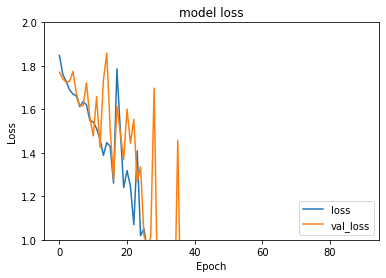

In [358]:
plot_loss_graph(vgg_vflip, 1, 2)

In [359]:
try:
  best_vgg_vflip = models.load_model("vgg_vflip.h5")
except NameError as error:
  print(error)
  best_vgg_vflip = loadmodel('best_vgg_vflip')

best_vgg_vflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 77ms/step - loss: 0.4109 - accuracy: 0.8837


[0.4109228253364563, 0.8837209343910217]

In [360]:
savemodel(best_vgg_vflip, 'best_vgg_vflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_vflip.h5



## Train on brightness Dataset

In [361]:
vgg_brightness = VGG()
vgg_brightness.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [362]:
callbacks_vgg_brightness = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("vgg_brightness.h5", save_best_only=True),
]

vgg_brightness.fit(train_data_brightness_gen, epochs=100,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_brightness)

Epoch 1/100
11/11 [==============================] - 7s 548ms/step - loss: 1.9605 - accuracy: 0.2250 - val_loss: 1.7747 - val_accuracy: 0.3023
Epoch 2/100
11/11 [==============================] - 6s 524ms/step - loss: 1.7685 - accuracy: 0.3548 - val_loss: 1.7602 - val_accuracy: 0.3488
Epoch 3/100
11/11 [==============================] - 6s 531ms/step - loss: 1.7169 - accuracy: 0.3814 - val_loss: 1.7527 - val_accuracy: 0.3721
Epoch 4/100
11/11 [==============================] - 6s 538ms/step - loss: 1.7156 - accuracy: 0.3702 - val_loss: 1.6850 - val_accuracy: 0.3721
Epoch 5/100
11/11 [==============================] - 6s 543ms/step - loss: 1.6378 - accuracy: 0.4079 - val_loss: 1.6542 - val_accuracy: 0.3953
Epoch 6/100
11/11 [==============================] - 6s 541ms/step - loss: 1.5840 - accuracy: 0.4330 - val_loss: 1.8232 - val_accuracy: 0.4419
Epoch 7/100
11/11 [==============================] - 6s 537ms/step - loss: 1.6033 - accuracy: 0.4248 - val_loss: 1.5815 - val_accuracy: 0.4419

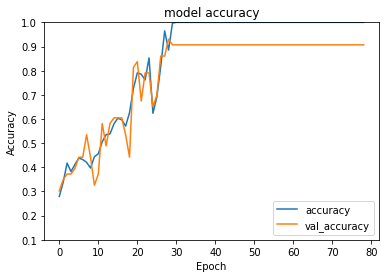

In [363]:
plot_accuracy_graph(vgg_brightness)

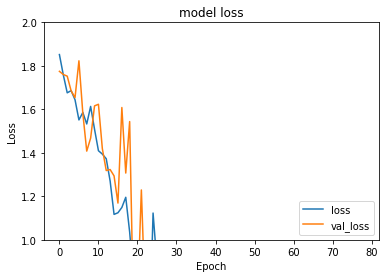

In [364]:
plot_loss_graph(vgg_brightness, 1, 2)

In [365]:
try:
  best_vgg_brightness = models.load_model("vgg_brightness.h5")
except NameError as error:
  print(error)
  best_vgg_brightness = loadmodel('best_vgg_brightness')

best_vgg_brightness.evaluate(val_data_gen)

2/2 [==============================] - 1s 74ms/step - loss: 0.4140 - accuracy: 0.9302


[0.4140382409095764, 0.930232584476471]

In [366]:
savemodel(best_vgg_brightness, 'best_vgg_brightness')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_brightness.h5



## Train on cropped and vertical flip Dataset

In [367]:
vgg_crop_vflip = VGG()
vgg_crop_vflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [368]:
callbacks_vgg_crop_vflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("vgg_crop_vflip.h5", save_best_only=True),
]

vgg_crop_vflip.fit(train_data_crop_vflip_gen, epochs=50,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_crop_vflip)

Epoch 1/50
22/22 [==============================] - 14s 591ms/step - loss: 1.9321 - accuracy: 0.2322 - val_loss: 1.7724 - val_accuracy: 0.3721
Epoch 2/50
22/22 [==============================] - 11s 516ms/step - loss: 1.7581 - accuracy: 0.3607 - val_loss: 1.7539 - val_accuracy: 0.3953
Epoch 3/50
22/22 [==============================] - 11s 518ms/step - loss: 1.7375 - accuracy: 0.3365 - val_loss: 1.7361 - val_accuracy: 0.3953
Epoch 4/50
22/22 [==============================] - 12s 522ms/step - loss: 1.6953 - accuracy: 0.3713 - val_loss: 1.7017 - val_accuracy: 0.3721
Epoch 5/50
22/22 [==============================] - 12s 520ms/step - loss: 1.6251 - accuracy: 0.4148 - val_loss: 1.7409 - val_accuracy: 0.3721
Epoch 6/50
22/22 [==============================] - 11s 519ms/step - loss: 1.6198 - accuracy: 0.4017 - val_loss: 1.6085 - val_accuracy: 0.3953
Epoch 7/50
22/22 [==============================] - 12s 520ms/step - loss: 1.5387 - accuracy: 0.4540 - val_loss: 1.6265 - val_accuracy: 0.3488

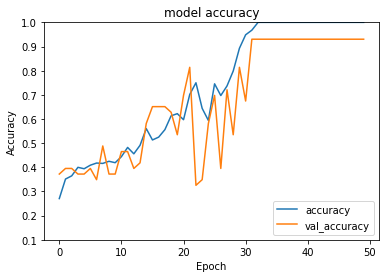

In [369]:
plot_accuracy_graph(vgg_crop_vflip)

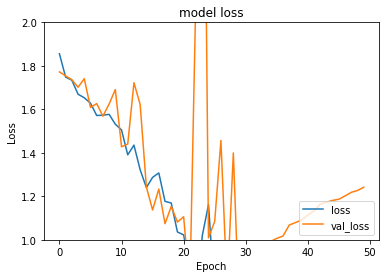

In [370]:
plot_loss_graph(vgg_crop_vflip, 1, 2)

In [371]:
try:
  best_vgg_crop_vflip = models.load_model("vgg_crop_vflip.h5")
except NameError as error:
  print(error)
  best_vgg_crop_vflip = loadmodel('best_vgg_crop_vflip')

best_vgg_crop_vflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 74ms/step - loss: 0.6216 - accuracy: 0.8140


[0.6215769648551941, 0.8139534592628479]

In [372]:
savemodel(best_vgg_crop_vflip, 'best_vgg_crop_vflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_crop_vflip.h5



## Train on cropped, vertical and horizontal flip Dataset

In [373]:
vgg_crop_vhflip = VGG()
vgg_crop_vhflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [374]:
callbacks_vgg_crop_vhflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("vgg_crop_vhflip.h5", save_best_only=True),
]

vgg_crop_vhflip.fit(train_data_crop_vhflip_gen, epochs=50,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_crop_vhflip)

Epoch 1/50
43/43 [==============================] - 25s 573ms/step - loss: 1.8412 - accuracy: 0.2612 - val_loss: 1.8368 - val_accuracy: 0.2791
Epoch 2/50
43/43 [==============================] - 23s 521ms/step - loss: 1.7677 - accuracy: 0.3224 - val_loss: 1.7596 - val_accuracy: 0.3488
Epoch 3/50
43/43 [==============================] - 22s 517ms/step - loss: 1.7461 - accuracy: 0.3097 - val_loss: 1.7790 - val_accuracy: 0.3953
Epoch 4/50
43/43 [==============================] - 22s 515ms/step - loss: 1.7405 - accuracy: 0.3284 - val_loss: 1.6976 - val_accuracy: 0.3488
Epoch 5/50
43/43 [==============================] - 22s 517ms/step - loss: 1.7134 - accuracy: 0.3453 - val_loss: 1.6260 - val_accuracy: 0.4419
Epoch 6/50
43/43 [==============================] - 22s 519ms/step - loss: 1.6559 - accuracy: 0.3394 - val_loss: 1.7076 - val_accuracy: 0.4651
Epoch 7/50
43/43 [==============================] - 22s 521ms/step - loss: 1.6917 - accuracy: 0.3352 - val_loss: 2.0245 - val_accuracy: 0.3256

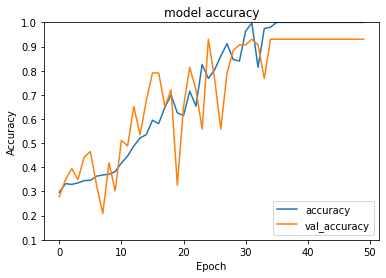

In [375]:
plot_accuracy_graph(vgg_crop_vhflip)

In [66]:
plot_loss_graph(vgg_crop_vhflip, 1, 2)

NameError: ignored

In [377]:
try:
  best_vgg_crop_vhflip = models.load_model("vgg_crop_vhflip.h5")
except NameError as error:
  print(error)
  best_vgg_crop_vhflip = loadmodel('best_vgg_crop_vhflip')

best_vgg_crop_vhflip.evaluate(val_data_gen)

2/2 [==============================] - 1s 74ms/step - loss: 0.3010 - accuracy: 0.9070


[0.30095991492271423, 0.9069767594337463]

In [378]:
savemodel(best_vgg_crop_vhflip, 'best_vgg_crop_vhflip')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_crop_vhflip.h5



## Train on cropped, vertical, horizontal flip and brightness Dataset

In [32]:
vgg_crop_vhflip_brightness = VGG()
vgg_crop_vhflip_brightness.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

80142336/80134624 [==============================] - 1s 0us/step


In [34]:
callbacks_vgg_crop_vhflip_brightness = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=30),
    ModelCheckpoint("vgg_crop_vhflip_brightness.h5", save_best_only=True),
]

vgg_crop_vhflip_brightness.fit(train_data_crop_vflip_hflip_brightness_gen, epochs=50,
           validation_data=val_data_gen, 
           callbacks=callbacks_vgg_crop_vhflip_brightness)

Epoch 1/50
91/91 [==============================] - 722s 8s/step - loss: 1.8830 - accuracy: 0.2871 - val_loss: 1.7137 - val_accuracy: 0.4419
Epoch 2/50
91/91 [==============================] - 42s 462ms/step - loss: 1.7488 - accuracy: 0.3148 - val_loss: 1.6623 - val_accuracy: 0.4186
Epoch 3/50
91/91 [==============================] - 43s 470ms/step - loss: 1.8099 - accuracy: 0.3024 - val_loss: 1.7833 - val_accuracy: 0.2326
Epoch 4/50
91/91 [==============================] - 43s 468ms/step - loss: 1.7971 - accuracy: 0.2799 - val_loss: 1.4484 - val_accuracy: 0.5116
Epoch 5/50
91/91 [==============================] - 43s 472ms/step - loss: 1.5171 - accuracy: 0.4225 - val_loss: 1.4301 - val_accuracy: 0.5349
Epoch 6/50
91/91 [==============================] - 43s 471ms/step - loss: 1.4209 - accuracy: 0.4373 - val_loss: 1.3181 - val_accuracy: 0.5116
Epoch 7/50
91/91 [==============================] - 43s 473ms/step - loss: 1.2875 - accuracy: 0.4976 - val_loss: 1.3540 - val_accuracy: 0.4651
E

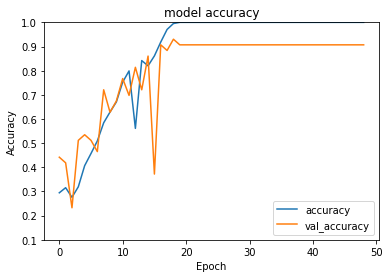

In [64]:
plot_accuracy_graph(vgg_crop_vhflip_brightness)

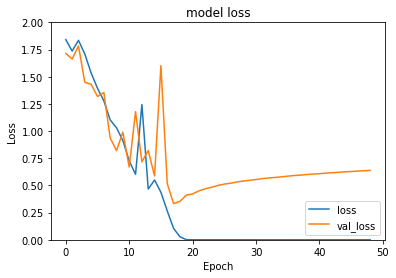

In [63]:
plot_loss_graph(vgg_crop_vhflip_brightness, 0, 2)

In [65]:
try:
  best_vgg_crop_vhflip_brightness = models.load_model("vgg_crop_vhflip_brightness.h5")
except NameError as error:
  print(error)
  best_vgg_crop_vhflip_brightness = loadmodel('best_vgg_crop_vhflip_brightness')
best_vgg_crop_vhflip_brightness.evaluate(val_data_gen)

2/2 [==============================] - 0s 66ms/step - loss: 0.3329 - accuracy: 0.8837


[0.3328571319580078, 0.8837209343910217]

In [58]:
best_vgg_crop_vhflip_brightness.evaluate(val_data_vhflip_brightness_gen)

11/11 [==============================] - 54s 5s/step - loss: 0.3279 - accuracy: 0.8866


[0.32789668440818787, 0.8866279125213623]

In [60]:
preds = best_vgg_crop_vhflip_brightness.predict(val_data_vhflip_brightness_gen,verbose=1)

Ypred = np.argmax(preds, axis=1)
Ytest = val_data_vhflip_brightness_gen.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=CLASS_NAMES, digits=3))

11/11 [==============================] - 2s 148ms/step
                   precision    recall  f1-score   support

   Density4Benign      1.000     0.938     0.968        16
   Density1Benign      1.000     0.800     0.889        40
Density3Malignant      0.889     1.000     0.941        24
   Density3Benign      0.889     0.600     0.716        40
Density4Malignant      1.000     1.000     1.000         8
   Density2Benign      1.000     1.000     1.000        16
Density1Malignant      0.907     0.917     0.912        96
Density2Malignant      0.803     0.942     0.867       104

         accuracy                          0.887       344
        macro avg      0.936     0.900     0.912       344
     weighted avg      0.894     0.887     0.884       344



In [61]:
savemodel(best_vgg_crop_vhflip_brightness, 'best_vgg_crop_vhflip_brightness')


Model saved successfully on file /content/drive/MyDrive/Colab Notebooks/models/best_vgg_crop_vhflip_brightness.h5



# Custom CNN

In [62]:
CNN = CustomCNN((IMG_WIDTH, IMG_HEIGHT, 3), 3, len(CLASS_NAMES), 1)
CNN2 = CustomCNN((IMG_WIDTH, IMG_HEIGHT, 3), 3, len(CLASS_NAMES), 2) #Same CNN with 2 layers of part A

## Train on plain Dataset

In [ ]:
custom_cnn = CNN.create_model()
custom_cnn.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn.h5", save_best_only=True),
]
custom_cnn.fit(train_data_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn)

In [ ]:
try:
  plot_accuracy_graph(custom_cnn)
except NameError as error:
  print(error)
  custom_cnn = loadmodel('best_custom_cnn')
  plot_accuracy_graph(custom_cnn)

In [ ]:
try:
  plot_loss_graph(custom_cnn, 1, 2)
except NameError as error:
  print(error)
  custom_cnn = loadmodel('best_custom_cnn')
  plot_loss_graph(custom_cnn, 1, 2)

In [ ]:
best_custom_cnn = models.load_model("custom_cnn.h5")
best_custom_cnn.evaluate(val_data_gen)

In [ ]:
savemodel(best_custom_cnn, 'best_custom_cnn')

## Train on plain Dataset with 2 layers cnn

In [ ]:
custom_cnn2 = CNN2.create_model()
custom_cnn2.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn2 = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn2.h5", save_best_only=True),
]
custom_cnn2.fit(train_data_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn2)

In [ ]:
try:
  plot_accuracy_graph(custom_cnn2)
except NameError as error:
  print(error)
  custom_cnn2 = loadmodel('best_custom_cnn2')
  plot_accuracy_graph(custom_cnn2)

In [ ]:
try:
  plot_loss_graph(custom_cnn2, 1, 2.1)
except NameError as error:
  print(error)
  custom_cnn2 = loadmodel('best_custom_cnn2')
  plot_loss_graph(custom_cnn2, 1, 2.1)

In [ ]:
best_custom_cnn2 = models.load_model("custom_cnn2.h5")
best_custom_cnn2.evaluate(val_data_gen)

## Train on cropped Dataset

In [ ]:
custom_cnn_crop = CNN.create_model()
custom_cnn_crop.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_crop = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_crop.h5", save_best_only=True),
]
custom_cnn_crop.fit(train_data_crop_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_crop)

In [ ]:
try:
  plot_accuracy_graph(custom_cnn_crop)
except NameError as error:
  print(error)
  custom_cnn_crop = loadmodel('best_custom_cnn_crop')
  plot_accuracy_graph(custom_cnn_crop)

In [ ]:
try:
  plot_loss_graph(custom_cnn_crop, 1, 2)
except NameError as error:
  print(error)
  custom_cnn_crop = loadmodel('best_custom_cnn_crop')
  plot_loss_graph(custom_cnn_crop, 1, 2)

In [ ]:
best_custom_cnn_crop = models.load_model("custom_cnn_crop.h5")
best_custom_cnn_crop.evaluate(val_data_gen)

In [ ]:
savemodel(best_custom_cnn_crop, 'best_custom_cnn_crop')

## Train on cropped Dataset with 2 layers

In [ ]:
custom_cnn_crop2 = CNN2.create_model()
custom_cnn_crop2.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_crop2 = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_crop2.h5", save_best_only=True),
]
custom_cnn_crop2.fit(train_data_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_crop2)

In [ ]:
try:
  plot_accuracy_graph(custom_cnn_crop2)
except NameError as error:
  print(error)
  custom_cnn_crop2 = loadmodel('best_custom_cnn_crop2')
  plot_accuracy_graph(custom_cnn_crop2)

In [ ]:
try:
  plot_loss_graph(custom_cnn_crop2, 1, 2.1)
except NameError as error:
  print(error)
  custom_cnn_crop2 = loadmodel('best_custom_cnn_crop2')
  plot_loss_graph(custom_cnn_crop2, 1, 2.1)

In [ ]:
custom_cnn_crop2 = models.load_model("custom_cnn_crop2.h5")
custom_cnn_crop2.evaluate(val_data_gen)

## Train on horizontal flip Dataset

In [ ]:
custom_cnn_hflip = CNN.create_model()
custom_cnn_hflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_hflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_hflip.h5", save_best_only=True),
]
custom_cnn_hflip.fit(train_data_hflip_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_hflip)

In [ ]:
try:
  plot_accuracy_graph(custom_cnn_hflip)
except NameError as error:
  print(error)
  custom_cnn_hflip = loadmodel('best_custom_cnn_hflip')
  plot_accuracy_graph(custom_cnn_hflip)

In [ ]:
try:
  plot_loss_graph(custom_cnn_hflip, 1, 2)
except NameError as error:
  print(error)
  custom_cnn_hflip = loadmodel('best_custom_cnn_hflip')
  plot_loss_graph(custom_cnn_hflip, 1, 2)

In [ ]:
best_custom_cnn_hflip = models.load_model("custom_cnn_hflip.h5")
best_custom_cnn_hflip.evaluate(val_data_gen)

In [ ]:
savemodel(best_custom_cnn_hflip, 'best_custom_cnn_hflip')

## Train on vertical flip Dataset

In [ ]:
custom_cnn_vflip = CNN.create_model()
custom_cnn_vflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_vflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_vflip.h5", save_best_only=True),
]
custom_cnn_vflip.fit(train_data_vflip_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_vflip)

In [ ]:
try:
  plot_accuracy_graph(custom_cnn_vflip)
except NameError as error:
  print(error)
  custom_cnn_vflip = loadmodel('best_custom_cnn_vflip')
  plot_accuracy_graph(custom_cnn_vflip)

In [ ]:
try:
  plot_loss_graph(custom_cnn_vflip, 1, 2)
except NameError as error:
  print(error)
  custom_cnn_vflip = loadmodel('best_custom_cnn_vflip')
  plot_loss_graph(custom_cnn_vflip, 1, 2)

In [ ]:
best_custom_cnn_vflip = models.load_model("custom_cnn_vflip.h5")
best_custom_cnn_vflip.evaluate(val_data_gen)

In [ ]:
savemodel(best_custom_cnn_vflip, 'best_custom_cnn_vflip')

## Train on brightness Dataset

In [ ]:
custom_cnn_brightness = CNN.create_model()
custom_cnn_brightness.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_brightness = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_brightness.h5", save_best_only=True),
]
custom_cnn_brightness.fit(train_data_brightness_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_brightness)

In [ ]:
try:
  plot_accuracy_graph(custom_cnn_brightness)
except NameError as error:
  print(error)
  custom_cnn_brightness = loadmodel('best_custom_cnn_brightness')
  plot_accuracy_graph(custom_cnn_brightness)

In [ ]:
try:
  plot_loss_graph(custom_cnn_brightness, 1, 2)
except NameError as error:
  print(error)
  custom_cnn_brightness = loadmodel('best_custom_cnn_brightness')
  plot_loss_graph(custom_cnn_brightness, 1, 2)

In [ ]:
best_custom_cnn_brightness = models.load_model("custom_cnn_brightness.h5")
best_custom_cnn_brightness.evaluate(val_data_gen)

In [ ]:
savemodel(best_custom_cnn_brightness, 'best_custom_cnn_brightness')

## Train on cropped and vertical flip Dataset

In [ ]:
custom_cnn_crop_vflip = CNN.create_model()
custom_cnn_crop_vflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_crop_vflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_crop_vflip.h5", save_best_only=True),
]
custom_cnn_crop_vflip.fit(train_data_crop_vflip_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_crop_vflip)

In [ ]:
try:
  plot_accuracy_graph(custom_cnn_crop_vflip)
except NameError as error:
  print(error)
  custom_cnn_crop_vflip = loadmodel('best_custom_cnn_crop_vflip')
  plot_accuracy_graph(custom_cnn_crop_vflip)

In [ ]:
try:
  plot_loss_graph(custom_cnn_crop_vflip, 1, 2)
except NameError as error:
  print(error)
  custom_cnn_crop_vflip = loadmodel('best_custom_cnn_crop_vflip')
  plot_loss_graph(custom_cnn_crop_vflip, 1, 2)

In [ ]:
best_custom_cnn_crop_vflip = models.load_model("custom_cnn_crop_vflip.h5")
best_custom_cnn_crop_vflip.evaluate(val_data_gen)

In [ ]:
savemodel(best_custom_cnn_crop_vflip, 'best_custom_cnn_crop_vflip')

## Train con cropped, vertical and horizontal flip Dataset

In [ ]:
custom_cnn_crop_vhflip = CNN.create_model()
custom_cnn_crop_vhflip.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_crop_vhflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_crop_vhflip.h5", save_best_only=True),
]
custom_cnn_crop_vhflip.fit(train_data_crop_vhflip_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_crop_vhflip)

In [ ]:
try:
  plot_accuracy_graph(custom_cnn_crop_vhflip)
except NameError as error:
  print(error)
  custom_cnn_crop_vhflip = loadmodel('best_custom_cnn_crop_vhflip')
  plot_accuracy_graph(custom_cnn_crop_vhflip)

In [ ]:
try:
  plot_loss_graph(custom_cnn_crop_vhflip, 1, 2)
except NameError as error:
  print(error)
  custom_cnn_crop_vhflip = loadmodel('best_custom_cnn_crop_vhflip')
  plot_loss_graph(custom_cnn_crop_vhflip, 1, 2)

In [ ]:
best_custom_cnn_crop_vhflip = models.load_model("custom_cnn_crop_vhflip.h5")
best_custom_cnn_crop_vhflip.evaluate(val_data_gen)

In [ ]:
savemodel(best_custom_cnn_crop_vhflip, 'best_custom_cnn_crop_vhflip')

## Train on cropped, vertical, horizontal flip and brightness Dataset

In [ ]:
custom_cnn_crop_vhflip_brightness = CNN.create_model()
custom_cnn_crop_vhflip_brightness.compile(SGD(lr=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callbacks_custom_cnn_crop_vhflip_brightness = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("custom_cnn_crop_vhflip_brightness.h5", save_best_only=True),
]
custom_cnn_crop_vhflip_brightness.fit(train_data_crop_vflip_hflip_brightness_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_custom_cnn_crop_vhflip_brightness)

In [ ]:
try:
  plot_accuracy_graph(custom_cnn_crop_vhflip_brightness)
except NameError as error:
  print(error)
  custom_cnn_crop_vhflip_brightness = loadmodel('best_custom_cnn_crop_vhflip_brightness')
  plot_accuracy_graph(custom_cnn_crop_vhflip_brightness)

In [ ]:
try:
  plot_loss_graph(custom_cnn_crop_vhflip_brightness, 1, 2)
except NameError as error:
  print(error)
  custom_cnn_crop_vhflip_brightness = loadmodel('best_custom_cnn_crop_vhflip_brightness')
  plot_loss_graph(custom_cnn_crop_vhflip_brightness, 1, 2)

In [ ]:
best_custom_cnn_crop_vhflip_brightness = models.load_model("custom_cnn_crop_vhflip_brightness.h5")
best_custom_cnn_crop_vhflip_brightness.evaluate(val_data_gen)

In [ ]:
savemodel(best_custom_cnn_crop_vhflip_brightness, 'best_custom_cnn_crop_vhflip_brightness')

# Random

# Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

# CAZZO DI CNN DEMMERDA

In [ ]:
#input_shape = (224, 224, 3)
#model = CNN(input_shape, len(CLASS_NAMES))
#model.summary()
# tf.keras.utils.plot_model(model, to_file="model.png")

In [ ]:
def CNN(in_shape):

  #needs to have N number of part A layers
  model = models.Sequential()

  #part A
  model.add(layers.Conv2D(3,input_shape = in_shape, kernel_size=(3,3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2)) # 0.2 dropout rate 
  model.add(layers.MaxPool2D())
  model.add(layers.GlobalAveragePooling2D())
  #model.add(layers.Flatten())

  #part B
  model.add(layers.Dense(32))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(8))
  model.add(layers.Softmax())
  return model

## Train on plain Dataset

In [ ]:
CNN = CNN((224, 224, 3))
#CNN.summary()

In [ ]:
CNN.compile(SGD(0.01), loss = 'kullback_leibler_divergence', metrics=['accuracy'])


In [ ]:
callbacks_cnn = [
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("cnn.h5", save_best_only=True),
]
CNN.fit(train_data_gen, epochs=100, validation_data=val_data_gen, callbacks=callbacks_cnn)

In [ ]:
plt.plot(CNN.history.history['accuracy'], label='accuracy')
plt.plot(CNN.history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 0.4])
plt.legend(loc='lower right')

In [ ]:
best_cnn = models.load_model("cnn.h5")

In [ ]:
best_cnn.evaluate(val_data_gen)

In [ ]:
preds = best_cnn.predict(val_data_gen,verbose=1)

Ypred = np.argmax(preds, axis=1)
Ypred = keras.utils.to_categorical(Ypred, num_classes)
Ytest = val_data_gen.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=CLASS_NAMES, digits=3))

## Train on cropped Dataset

In [ ]:
CNN_crop = CNN((224, 224, 3))
CNN_crop.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'])


In [ ]:
callbacks_cnn_crop = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("cnn_crop.h5", save_best_only=True),
]
CNN_crop.fit(train_data_crop_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_cnn_crop)

In [ ]:
plt.plot(CNN_crop.history.history['accuracy'], label='accuracy')
plt.plot(CNN_crop.history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

In [ ]:
best_cnn_crop = models.load_model("cnn_crop.h5")

In [ ]:
best_cnn_crop.evaluate(val_data_gen)

##Train on horizontal flip Dataset

In [ ]:
CNN_hflip = CNN((224, 224, 3))
CNN_hflip.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'])


In [ ]:
callbacks_cnn_hflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("cnn_hflip.h5", save_best_only=True),
]
CNN_hflip.fit(train_data_crop_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_cnn_hflip)

In [ ]:
plt.plot(CNN_hflip.history.history['accuracy'], label='accuracy')
plt.plot(CNN_hflip.history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

In [ ]:
best_cnn_hflip = models.load_model("cnn_hflip.h5")

In [ ]:
best_cnn_hflip.evaluate(val_data_gen)

##Train on vertical flip Dataset

In [ ]:
CNN_vflip = CNN((224, 224, 3))
CNN_vflip.compile(optimizer='adam', loss = 'kullback_leibler_divergence', metrics=['accuracy'])


In [ ]:
callbacks_cnn_vflip = [
    # TensorBoard(update_freq=6),
    EarlyStopping(monitor='val_accuracy', patience=50),
    ModelCheckpoint("cnn_vflip.h5", save_best_only=True),
]
CNN_vflip.fit(train_data_crop_gen, epochs=50, validation_data=val_data_gen, callbacks=callbacks_cnn_vflip)

In [ ]:
plt.plot(CNN_vflip.history.history['accuracy'], label='accuracy')
plt.plot(CNN_vflip.history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

In [ ]:
best_cnn_vflip = models.load_model("cnn_vflip.h5")

In [ ]:
best_cnn_vflip.evaluate(val_data_gen)

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
for f in list_ds.take(8):
  print(f.numpy())


def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

IMG_WIDTH, IMG_HEIGHT = 224,224
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(labeled_ds)

In [ ]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    plt.imshow(image)
    # plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
    # plt.axis('off')


In [ ]:
labeled_ds.take(3)

In [ ]:


history = resnet.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

In [ ]:
STEPS_PER_EPOCH = np.ceil(image_count/32)